# Analisis de variables 

En este cuaderno se explora que variables se tienen, esto con el objetivo de poder identificar modelo que se ajusten a las necesidades de predicción. En primer lugar se hace la carga de datos desde un archivo binario que se obtiene de una petición SQL hecha anteriormente

In [1]:
import pickle5 as pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.signal import argrelextrema
from datetime import timedelta
import smtplib
import ssl
import seaborn as sns 
import random 
from callbacks import EarlyStoppingMinLoss
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

import torch
from torch import nn
import torch.optim as optim

from model import LSTMModel, Opt
import holidays
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import os
import tensorflow as tf
os.environ['KMP_DUPLICATE_LIB_OK']='True'

Using TensorFlow backend.


cpu disponible!


In [2]:
filename = "data.ftr"

with open(filename, "rb") as fh:
    data = pickle.load(fh)
    
data = pd.DataFrame(data)

In [3]:
data

,ID_FECHA_CONSULTADA,ANIO_CARTERA,MES_CARTERA,ANIOMES_CARTERA,NUMERO_CONTRATO,TIPO_IDENTIFICACION,IDENTIFICACION,SEXO,INGRESO,REPUTACION_CLIENTE,...,CANTIDAD_FACTURAS_CON_MORA,FECHA_REGISTRO_CARTERA,FECHA_COBRO,FECHA_PAGO,FECHA_RECAUDO,ID_CONTRATO,ID_CLIENTE,ID_GEOGRAFIA,ID_REGION_NATURAL,REGION
0,20181201.0,2018,11,201811,758589809482,5,30567722,F,2454284.0,4.0,...,0.0,2018-11-23,2018-12-08,2018-11-26,2018-11-27,8689.0,3929.0,54670.0,2.0,Centro Oriente
1,20190101.0,2018,12,201812,830910315567,2,11642038,M,5492814.0,5.0,...,0.0,2018-12-23,2019-01-07,2018-12-27,2018-12-28,11372.0,5614.0,54670.0,2.0,Centro Oriente
2,20190101.0,2018,12,201812,915320322651,3,72850794,M,5946697.0,3.0,...,0.0,2018-12-23,2019-01-07,2018-12-24,2018-12-25,7070.0,6182.0,5480.0,4.0,Eje Cafetero - Antioquia
3,20190101.0,2018,12,201812,754486263805,5,71620041,F,5489184.0,5.0,...,0.0,2018-12-23,2019-01-07,2019-01-01,2019-01-02,10940.0,2145.0,5480.0,4.0,Eje Cafetero - Antioquia
4,20190201.0,2019,01,201901,482290887380,1,46788645,F,5005455.0,5.0,...,0.0,2019-01-23,2019-02-07,2019-01-27,2019-01-28,12811.0,3294.0,5040.0,4.0,Eje Cafetero - Antioquia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182774,20150801.0,2015,07,201507,396932713330,3,28314231,M,1806612.0,4.0,...,0.0,2015-07-23,2015-08-07,2015-07-25,2015-07-26,6678.0,10605.0,25426.0,2.0,Centro Oriente
182775,20150801.0,2015,07,201507,442296544038,4,78176770,M,609600.0,4.0,...,0.0,2015-07-23,2015-08-07,2015-07-23,2015-07-24,5952.0,8766.0,27205.0,6.0,Pacífico
182776,20150801.0,2015,07,201507,700030420895,1,68350115,M,2177628.0,5.0,...,0.0,2015-07-23,2015-08-07,2015-07-30,2015-07-31,12480.0,9006.0,81300.0,5.0,Llano
182777,20150801.0,2015,07,201507,919730907694,2,7059347,F,1539082.0,4.0,...,0.0,2015-07-23,2015-08-07,2015-08-04,2015-08-05,8604.0,797.0,52256.0,6.0,Pacífico


## Construcción de serie temporal binaria

Para hacer una predicción inicial del modelo se pretende adoptar la columna de datos de __FECHA PAGO__ y convertirla en una serie binaria, para de esta manera tratar de hacer una predicción a futuro de la fecha de pago. 

Veamos como se distribuye el pago de un producto a través del tiempo, para esto se construye una función del tiempo que permita ver el comportamiento , veamos cuantos productos se tiene en la base de datos 

In [4]:
n_products = len(data["ID_CONTRATO"].value_counts())
print("Numero de productos existentes en la base de datos = {}".format(n_products))

Numero de productos existentes en la base de datos = 7230


Para poder hacer un estudio se elige un producto al azar de los encontrados anteriormente

In [5]:
#producto_x = data["ID_CONTRATO"].value_counts().index[900]
producto_x = 11575
#producto_x = 6840
print("Producto seleccionado = {}".format(producto_x))

Producto seleccionado = 11575


Se hace un filtro por producto para elegir las fechas en las cual se tiene el pago del producto seleccionado 

In [6]:
fecha_pago = data["FECHA_PAGO"][data["ID_CONTRATO"]==producto_x].sort_values(ascending=True)
fecha_pago = pd.to_datetime(fecha_pago)
fecha_pago


73965    2019-04-23
11734    2019-05-27
167444   2019-07-05
13410    2019-07-25
121495   2019-09-06
17912    2019-10-07
141736   2019-10-25
113801   2019-11-26
55592    2019-12-23
175127   2020-02-05
83829    2020-02-25
85765    2020-04-05
Name: FECHA_PAGO, dtype: datetime64[ns]

Para ver como es el comportamiento de pago se hace una linea de tiempo y anotar con in indicar en el momento en el que el cliente realiza el pago 

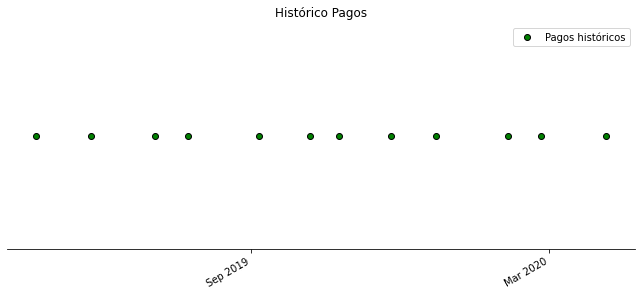

In [7]:
name_pay = ["pago "+str(i) for i in range(1, len(fecha_pago))]
levels = np.tile([5], int(np.ceil(len(fecha_pago)/6)))[:len(fecha_pago)]

# Create figure
fig, ax = plt.subplots(figsize=(8.8, 4), constrained_layout=True)
# put title
ax.set(title="Histórico Pagos")
ax.plot(fecha_pago, np.zeros_like(fecha_pago), "ro",
        color="k", markerfacecolor="g", label="Pagos históricos")  

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.setp(ax.get_xticklabels(), rotation=30, ha="right")

# remove y axis and spines
ax.yaxis.set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)


plt.legend()

La intención del programa será predecir en que fecha se realizará el siguiente pago, en simples terminos, en que momento del tiempo se ubicará el siguiente punto verde. Sin embargo aún faltan anotar todas las fechas completas para conmesurar y tener los datos de cada cuanto se hace el pago. Se crea un vector que contenga todos los días desde el inicio del primer pago, hasta el ultimo registrado 

In [8]:
first_pay = fecha_pago.min()
last_pay  = fecha_pago.max() 
time_product = pd.date_range(first_pay, last_pay)
print("Dias de vida del producto = {}".format(len(time_product)))
print("Pago hechos = {}".format(len(fecha_pago)))

Dias de vida del producto = 349
Pago hechos = 12


para poder evidenciar el pago, se debe crear un vector que registre cuando se hizo el pago y cuando no para tener claridad. Esto se hace creando un vector lleno de ceros y nada mas asigando uno cuando se tenga una fecha de pago. Adicional a esto se hace un mapeo de la fechas a un vector de etiquetas, es decir, se crea un vector alternativo que registra las fechas con numeros. Por ejemplo a la primera fecha registrada se le asigna el valor 1, a la siguiente el 2 y asi sucesivamente hasta completar los d'ias registrados en la base de datos 

(349,)
(349,)


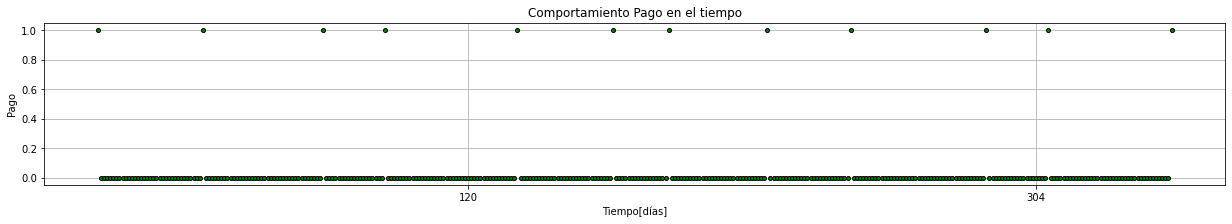

In [9]:
# vector de ceros 
pagos = np.zeros(len(time_product))
print(np.shape(pagos))
#vector de etiqueta de tiempo 
labels_time = np.arange(len(time_product))
print(np.shape(labels_time))
# se identifican las fechas de pago dentro del vector de tiempo de vida del producto
for i in range(len(fecha_pago)):
    index_to_replace = np.where(time_product == fecha_pago.iloc[i])
    pagos[index_to_replace] = 1

fig, ax = plt.subplots(figsize=(17, 3), constrained_layout=True)
ax.set(title="Comportamiento Pago en el tiempo")
ax.plot(labels_time, pagos, "ro", color="k", markerfacecolor="g", markersize=4)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
ax.set_xlabel("Tiempo[días]")
ax.set_ylabel("Pago")
plt.grid(True)

En el orden de hacer la predicción se quiere hacer un forecasting de una serie de tiempo binaria, que me prediga el dia siguiente de pago teniendo en cuenta toda la historia anterior del comportamiento de este producto, respecto del día cero del producto. Para poder hacer testeo se requiere separar los últimos 30 días de pago como conjunto de validación. 

In [10]:
test_size = 90

labels_time_train = labels_time[:-test_size]
pagos_train = pagos[:-test_size]
labels_time_test = labels_time[-test_size:]
pagos_test = pagos[-test_size:]

# Redes neuronales recurrentes 
## Constuyendo un modelo LSTM

En el vasto campo de aplicacion de Redes NEuronales Convolucionales (RNN) por su siglas en ingles, se incluye la predicción secuencial, reconocimiento de activifdad , clasificación de video y una variedad de tareas que aún se encuentran en desarrollo. 

Podemos acá acuñar una frase con toda la autoridad y si se insiste en utilizar la tecnología sin comprender como funciona, es probable que falle. La abstracción de la programación orientada a objetos no permite a los usuarios de código entender cómo manejamos la dimensión del tiempo en secuencias, sin embargo , al comprender como funciona , puede escribir código optimizado y rpacticar la extensibilidad y adaptación ante diferentes problemas. 

## Celda simple RNN

LAs celdas recurrentes son redes neuronales (generalmente pequeñas) para procesar datos secueciales. Como es sabido, las capa convolucionales están especializadas para procesar valores estructurados en matrices. Por el contrario las capas recurrentes están diseñadas para procesar secuencias largas, sin niguna eleccion de diseño adicional. 

Se propone solucionar esto conectando la salida de los pasos de tienpo a la entrada. A esto se le llama "unroling". Al procesar toda la secuencia, tenemos un algoritmo que tiene en cuenta estados previos de la secuenia. De esta manera se tiene la primera noción de memoria dentro de una celda, 

<img src="rnn-cell.png">

La mayoria de la celdas recurrentes comunes también pueden procesar secuencias de longitud varibale. Esto es realmente importante para muchas aplicaciones, como videos, que contienen un número diferente de imagenes, por poner un ejemplo. Se puede ver la celda RNN como una red neuronal común con pasos de tienpo. Con esta modificación, los pesos de la celda ahora tienen acceso a los estados anteriores a la secuencia. La pregunta pertienente ahora es, ¿cómo entrenar estos modelos secuenciales?



## ¿qué es la retropropagación a través del tiempo?

Si se desea encontrar una solución eficiente a un problema particular, se debe diseñar cuidadosamente la arquitectura en función al problema. La magia de las redes RNN que nadie ve es la entrada que se desenrrolla. Esto significa que , dada una secuencia de longitud $N$, se procesa la entrada dentro de pasos de tiempo.

Se elige modelar la dimensión del tiempo con RNN, porque se quiere aprender dependencias temporales a corto y largo plazo. Entonces, ¿cómo aprender una secuencia de tiempo?. La idea principal debería ser que los pesos tuvieran en cuenta todas las secuencias de entrada. De lo contrario, no se podría aprender el mapeo deseado, en esencia , la propagación hacia atrás requiere una capa separada para cada paso de tiempo con los mismos pesos para todas las capas. Vemos un diagrama para poder entender mejor la idea

<img src="backpropagation.png">



La retropropagación hacia atras a través del tiempo se creó basándose en la observación descrita previamente. Entonces, según la entrada se puede calcular una pérdida diferente por paso de tiempo. Luego se puede propagar hacia atrás el rror de múltiples pérdidas a las celdas de memoria. En ese orden de ideas se pueden calcular los gradientes de múltiples rutas (pasos de tiempo) que luego se agregan para calcular el gradiente final. Por esta razón, se pueden utilizar diferentes optimizadores o métoidios de normalización en arquitecturas recurrentes.

En otras palabras, se representa la RNN como una red que repite "feedforward". 

## LSTM : Céldas de memoria a largo plazo ¿Cómo funcionan?

Se puede describir de manera esquematica y en una prosa interminable el trabajo de una celda LSTM, sin embargo el lenguaje de las matemáticas hace que este concepto sea compacto para las aplicaciones concretas. 

Antes de empezar se debe tener en cuenta que en todas las ecuaciones, las matrices de peso $W$ estám indexadas, siendo el primer índice el vector que se procesa, mientras que el segund índice se refiere a la representacion (puerta de entrada/olvido). Para definir la notación se consideran a las matrices con letras mayúsculas , mientras que los vectores con letras no mayusculas. Para la multiplicación por elementos se utiliza el punto con el símbolo del circulo exterior denominado el producto Hadamard.

Para cada $x_{t} \in R^{N}$, donde $N$ es la longitud de la característica a cada paso de tiempo y además $i_{t}, f_{t}, o_{t}, h_{t}, h_{t-1}, c_{t}, c_{t-1}, b \in R^{H}$, donde $H$ es la dimensión del estado oculto.

Para esto se tiene el sistema de ecuaciones:

1. __Puerta de entrada:__

$$i_{t} = \sigma(W_{\mathcal{X}i}x_{t} + W_{\mathcal{H}i}h_{t-1}+W_{\mathcal{C}i}c_{t-1}+b_{i})$$

las matrices de peso representan la memoria de la celda $x{t}$ en el tiempo actual mientras que $h$ y $c$ están indexadas con el paso de tiempo anterior. Cada matriz $W$ es una capa lineal (o una multiplicación de matrices). Esto permite tomar múltiples combinaciones lineales de $x$, $h$ y $c$ y además hacer coincidir las dimensionalidad de la entrada $x$ con la de $h$ y $c$.


LAs dimensionalidades de $h$ y $c$ son básicamente el parámetro de estados ocultos en un marco de aprendizaje profundo, este caso pytorch. Continuando, el termino de sesgo es parte de la capa lineal y es simplemente un vector que se entrena y se agrega, sin más. Finalmente, después de las tres cpas lineales de diferentes entredas, tenemos una función de activación no lineal para introducir no linealidades , lo que permite el aprendizaje de representaciones más complejas. En este caso, de manera regular se utiliza la función sigmoide.

2. __Puerta de olvido:__

$$f_{t} = \sigma(W_{\mathcal{X}f}x_{t}+W_{\mathcal{H}t}h_{t}+W_{\mathcal{C}f}c_{t}+b_{f})$$

LA anterior ecuación es exactamente igual que la ecuación anterior, sin embargo, se debe tener en cuenta que las matrices de pesos son diferentes esta vez. Esto signifia que obtenemos un conjunto diferente de combiancione lineales, que a su vez representan cosas diferentes.

3. __Vector de celda/contexto:__

$$c_{t} = f_{t}\odot c_{t-1}+i_{t}\odot\tanh(W_{\mathcal{X}c}x_{t}+b_{c})$$

se ha planteado la idea de "olvidar", también el modelamiento del vetor de enrtada, que ene este caso sería el vector $f$ e $i$, respectivamente. Se revisa antes que nada el termino concerniente con la tangente hiperbólica.

Se tiene otra combinación lineal del vector de entrada oculto, este término se relaciona con la nueva información de la celda, transmitida por la función $\tanh$ para introducir la no linealidad y estabilizar el entrenamiento. En este punto es importante mencionar que no se quiere actualizar la celda con los nuevos estados. Intuitivamente , queremos tener en cuenta estados anteriores, en este punto entra en juego el vector de entrada $i$. Se filtra la nueva información de celda aplicando una multiplicación de elementos con el vector de puerta de entrada $i$, como cuando se hacen filtros de pasa baja en procesamiento de señales, por ejemplo.

El vector de puerta de olvido entra en juego en este momento. En lugar de simplemente agregar información de entrada filtrada, realiza primero una multipliación vectorial por elementos con el vector de contexto anterior. Con este fin , se imita la noción de olvido de los humanos como filtro de multiplicación. Al agregar el término anteriormente descrito, el del paréntesis de la tangente hiperbólica, se obtiene el nuevo estado de celda

4. __La salida casi nueva:__

$$o_{t} = (W_{\mathcal{X}o}x_{t}+W_{\mathcal{H}o}h_{t-1}+W_{\mathcal{C}o}c_{t}+b_{o})$$

Se toma otra combinación lineal esta vez de los siguientes vectores $x_{t}$, $h(t-1)$, $c_{t}$, mientras que se añade al final otra función linenal. Se usa el nuevo estado de la celda calculado $c_{t}$ en lugar de la de los pasos 1 y 2

5. __El nuevo contexto:__

$$h_{t} = o_{t}\tanh(c_{t})$$

En este punto se afirma que las LSTM modelan información contextual. En lugar de producir una salida como se muestra en la anterior ecuación, se inyecta además el llamado vector de contexto. Mirando hacia atrás, las ecuaciones 1 y 2, se puede observar que el contexto anterior estaba involucrado. De esta manera, se involucra información basada en pasos de tiempo anteriores. Est oción de contexto permitió modelar correlaciones temporales en secuencias temporales en secuencias de largo plazo.


<img src="LSTM_unit.png">

Básicamente , una sola celda recibe como entrada la celda y el estado oculto del paso del tiempo anterior, así como el vector de entrada del paso de tiempo actual. Cada celda de LSTM genera el nuevo estado de celda y un estado oculto, que se utilizará para procesar el siguiente paso de tiempo. La salida de la celda, si es necesaria, por ejemplo, en la siguiente capa, es su estado oculto.

In [11]:
features_set = list()
labels = list()

Nt = len(pagos_train)- test_size

for i in range(Nt, len(pagos_train)):
    features_set.append(pagos_train[i-Nt:i])
    labels.append(pagos_train[i])

features_set, labels = np.array(features_set), np.array(labels)
features_set.shape

(90, 169)

Para entrenar la red LSTM a pattir de estos datos, se necesita convertir los datos a una forma que la red Neuronal entienda. Esto es un tensor , un formato de matrices tridimensional. La primera dimensión es el número de registros o filas en el conjunto de datos 

In [12]:
features_set = np.reshape(features_set, (features_set.shape[0], features_set.shape[1], 1))
features_set.shape

(90, 169, 1)

Se han redimensionado los datos, en este momento se propone el modelo LSTM. El modelo que se va a crear es un modelo secuencial con múltiples capas, en principio se agregan cuatro capas LSTM al modelo seguida de una capa densa que predice el día futuro de pago.

In [64]:
model = Sequential()
model.add(LSTM(units=1, return_sequences=True, input_shape=(features_set.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=2, return_sequences=True, activation="sigmoid", recurrent_activation="sigmoid"))
model.add(Dropout(0.2))
model.add(LSTM(units=8, return_sequences=True, activation="sigmoid", recurrent_activation="sigmoid"))
model.add(Dropout(0.2))
model.add(LSTM(units=16, return_sequences=True, activation="sigmoid", recurrent_activation="sigmoid"))
model.add(Dropout(0.2))
model.add(LSTM(units=32, return_sequences=False, activation="sigmoid", recurrent_activation="sigmoid"))
model.add(Dropout(0.2))
model.add(Dense(units = 1, activation="sigmoid"))

Ahora se compila el modelo, Se utiliza como función de pérdida la entropía binaria cruzada. Calcula cada una de las probabilidades predichas con la salida real de la clase, que puede ser 0 o 1. Luego clacula la puntuación que penaliza las probabilidades basándose en la distancia desde el valor esperado. Cuantifica que tan lejos está del valor real

LA definición formal se basa en el promedio negativo del logaritmo de las probabilidades predichas.

$$Loss$$

$$ECM = \frac{1}{n}\sum^{n}_{i=1}(\hat{y}_{i}-y_{i})$$


In [65]:
model.compile(optimizer="adam", 
              #loss="binary_crossentropy", 
              loss=[tf.keras.losses.Poisson()], 
              #loss = [tf.keras.losses.Huber()],
              #metrics=['accuracy']
              metrics=["accuracy"]
             )
             


Ahora es el momento del entrenamiento del modelo que se definió anteriormente. Se hace una prueba para ver que tanto se demora el modelo 

In [66]:
model.fit(features_set, labels, epochs = 100, batch_size = 32, callbacks=[EarlyStoppingMinLoss(patience=5)])

Epoch 1/100
90/90 [==============================] - 7s 81ms/step - loss: 0.5973 - accuracy: 0.1556
Epoch 2/100
90/90 [==============================] - 2s 27ms/step - loss: 0.5505 - accuracy: 0.3444
Epoch 3/100
90/90 [==============================] - 2s 27ms/step - loss: 0.5123 - accuracy: 0.5667
Epoch 4/100
90/90 [==============================] - 2s 28ms/step - loss: 0.4820 - accuracy: 0.7667
Epoch 5/100
90/90 [==============================] - 2s 27ms/step - loss: 0.4283 - accuracy: 0.8889
Epoch 6/100
90/90 [==============================] - 2s 27ms/step - loss: 0.3906 - accuracy: 0.9333
Epoch 7/100
90/90 [==============================] - 2s 26ms/step - loss: 0.3670 - accuracy: 0.9556
Epoch 8/100
90/90 [==============================] - 2s 27ms/step - loss: 0.3356 - accuracy: 0.9667
Epoch 9/100
90/90 [==============================] - 2s 27ms/step - loss: 0.2952 - accuracy: 0.9556
Epoch 10/100
90/90 [==============================] - 2s 27ms/step - loss: 0.2789 - accuracy: 0.9667

Una vez entrenado el modelo LSTM, es el momento de probar el rendimiento de nuestro algoritmo en el conjunto de prueba al predecir los precios de pago en el siguiente mes, es decir, 30 días después del último día registrado en el conjunto de entrenamiento. Para cada día del mes siguiente que queremos predecir se debe tener los 120 días anteriores. Entonces se deben concatenar los datos de validación y de entrenamiento. 

Es importante anotar que para esta etapa de desarrollo se tienen los datos consignados en las variables iniciales de lectura, de otra manera si se tienen datos de testeo independientes se deben concatenar para tener el conjunto de datos completo y poder hacer la preparación adecuadoa para someter al modelo.

Ahora se prepara las entradas al modelo de prueba. La entrada para cada día debe contener los datos de pago de 120 días anteriores y los 30 datos para la predicción, se constuye el vector con estos 150 valores

In [67]:
test_inputs = pagos[len(pagos) - len(pagos_test) - Nt:]
test_inputs = test_inputs.reshape(-1,1)


Finalmente se prepara el conjunto de entrada del modelo de prueba final que contendrá los $Nt$ días anteriores del histórico para los siguientes 90 días.

In [68]:
test_features = list()
for i in range(Nt, Nt+test_size):
    test_features.append(test_inputs[i-Nt:i])

test_features = np.array(test_features)
test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1))

Ahora se hace la predicción de los datos prueba 

In [69]:
predictions = model.predict_proba(test_features)

Se hace una grafica que resuma las predicciones en 90 días y que clarifique las fechas que el modelo está haciendo predicción para los días mencionados anteriormente. 

Última fecha de fago registrada = 2020-04-05


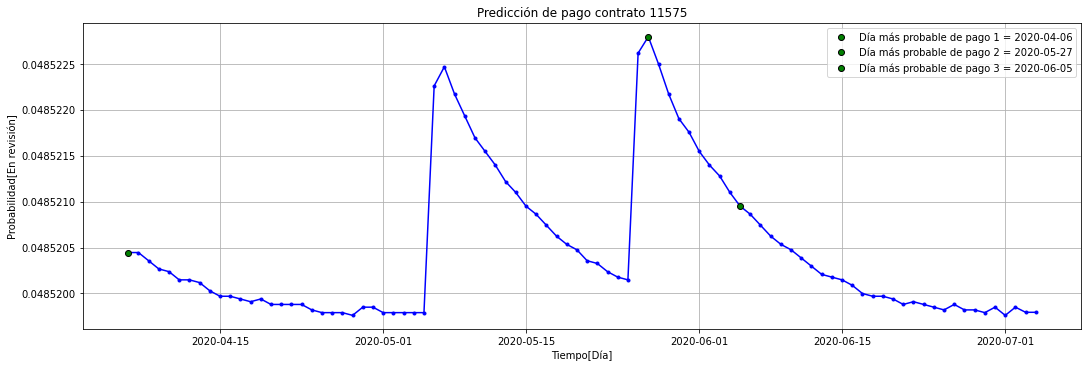

In [70]:
fechas = time_product[-test_size:] + timedelta(days=test_size)
fig, ax = plt.subplots(figsize=(15, 5), constrained_layout=True)
plt.plot(fechas, predictions, "b-")
plt.plot(fechas, predictions, "b.")

if test_size == 30:
    day1 = np.argmax(predictions[:30])
    plt.plot(fechas[day1], predictions[day1], "ro",label = "Día más probable de pago 1 = {}".format(fechas[day1]),
        color="k", markerfacecolor="g")
if test_size == 60:
    day1 = np.argmax(predictions[:30])
    day2 = np.argmax(predictions[31:-1]) + 30
    plt.plot(fechas[day1], predictions[day1], "ro",label = "Día más probable de pago 1 = {}".format(fechas[day1]),
        color="k", markerfacecolor="g")
    plt.plot(fechas[day2], predictions[day2], "ro",label = "Día más probable de pago 2 = {}".format(fechas[day2]),
        color="k", markerfacecolor="g")
if test_size == 90:
    day1 = np.argmax(predictions[:30])
    day2 = np.argmax(predictions[30:60]) + 30
    day3 = np.argmax(predictions[60:-1]) + 60
    plt.plot(fechas[day1], predictions[day1], "ro",label = "Día más probable de pago 1 = {}".format(fechas[day1].date()),
        color="k", markerfacecolor="g")
    plt.plot(fechas[day2], predictions[day2], "ro",label = "Día más probable de pago 2 = {}".format(fechas[day2].date()),
        color="k", markerfacecolor="g")
    plt.plot(fechas[day3], predictions[day3], "ro",label = "Día más probable de pago 3 = {}".format(fechas[day3].date()),
        color="k", markerfacecolor="g")
    
plt.title("Predicción de pago contrato "+str(int(producto_x)))
plt.xlabel("Tiempo[Día]")
plt.ylabel("Probabilidad[En revisión]")
plt.grid(True)
plt.legend()
print("Última fecha de fago registrada = {}".format(data[data["ID_CONTRATO"]==producto_x]["FECHA_PAGO"].max().date()))

Se hace evidente que el modelo trata de capturar el comportamiento histórico del modelo. Sin embargo no se tiene generalidad al momento de encontrar máximos en esta predicción, por esta razón se hace necesario construir una rutina que encuentre los máximos locales.


Última fecha de fago registrada = 2020-04-05


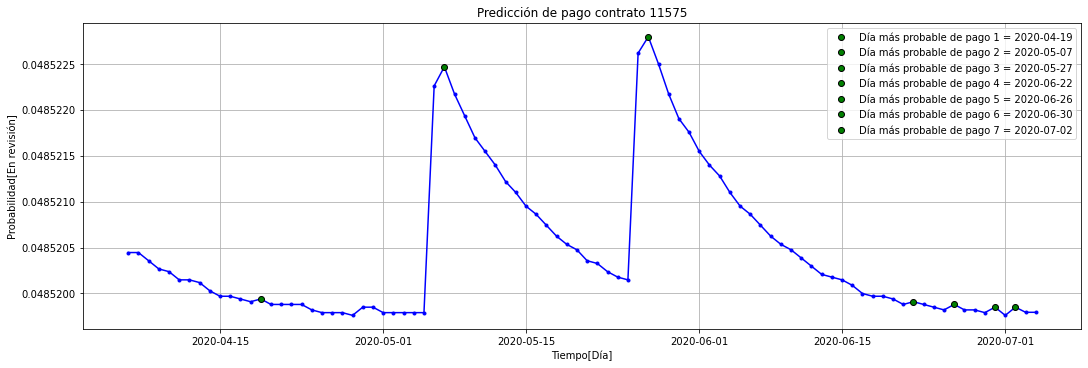

In [71]:
fechas = time_product[-test_size:] + timedelta(days=test_size)
fig, ax = plt.subplots(figsize=(15, 5), constrained_layout=True)

ind_max = argrelextrema(predictions, np.greater)[0]

prefix = "Día más probable de pago {} = "
prefix_date = [ prefix.format(i+1) for i in range(len(ind_max)) ]

plt.plot(fechas, predictions, "b-")
plt.plot(fechas, predictions, "b.")
for i in range(len(ind_max)):
    plt.plot(fechas[ind_max[i]], predictions[ind_max[i]], "ro",label=prefix_date[i]+ "{}".format(fechas[ind_max[i]].date()),
        color="k", markerfacecolor="g")

plt.title("Predicción de pago contrato "+str(int(producto_x)))
plt.xlabel("Tiempo[Día]")
plt.ylabel("Probabilidad[En revisión]")
plt.grid(True)
plt.legend()
print("Última fecha de fago registrada = {}".format(data[data["ID_CONTRATO"]==producto_x]["FECHA_PAGO"].max().date()))

Se hace una grafica de linea temporal para ver si la predicción está acorde al comportamiento a través del tiempo de vida del producto

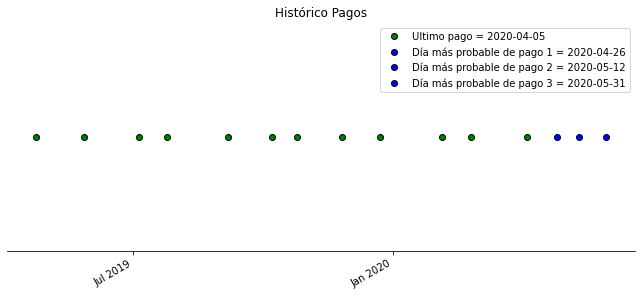

In [57]:
# Create figure
fig, ax = plt.subplots(figsize=(8.8, 4), constrained_layout=True)
# put title
ax.set(title="Histórico Pagos")
ax.plot(fecha_pago, np.zeros_like(fecha_pago), "ro",
        color="k", markerfacecolor="g", label="Ultimo pago = {}".format(data[data["ID_CONTRATO"]==producto_x]["FECHA_PAGO"].max().date())) 


for i in range(len(ind_max)):
    ax.plot(fechas[ind_max[i]], np.zeros_like(fechas[ind_max[i]]), "ro",label=prefix_date[i]+ "{}".format(
        
        fechas[ind_max[i]].date()),
        color="k", markerfacecolor="b")


#ax.plot(fechas[day1], np.zeros_like(fechas[day1]), "ro",
#        color="k", markerfacecolor="b", label="Predicción 1 = {}".format(fechas[day1].date())) 
#ax.plot(fechas[day2], np.zeros_like(fechas[day2]), "ro",
#        color="k", markerfacecolor="b", label="Predicción 2 = {}".format(fechas[day2].date()))
#ax.plot(fechas[day3], np.zeros_like(fechas[day3]), "ro",
#        color="k", markerfacecolor="b", label="Predicción 3 = {}".format(fechas[day3].date()))

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.setp(ax.get_xticklabels(), rotation=30, ha="right")
# remove y axis and spines
ax.yaxis.set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.legend()

Sin embargo aún no se sabe lo que para el algoritmo es un buen cliente, y se definira entonces en relación a la idea de un pago periodico. Para esto se propone utilizar el error cuadratico medio, que es la raíz cuadrada de la media del cuadrado de todos los errores. 

$$RMSE = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(\hat{y}_{i}-y_{i})^{2}}$$

en donde $\hat{y}_{i}$ es la observación verdadera y $y_{i}$ es la predición, veamos el calculo del RMSE para un determinado cliente


In [48]:
# Creacion de la fecha de pago sintética, es decir para esto se hace un vector de pagos periódicos tomando como referencia la primera fecha de pago del producto
# y creando un vector de tamaño iguak que el tiempo de vida del producto 
first_pay = fecha_pago.min()
last_pay  = fecha_pago.max()
yhat = pd.date_range(fecha_pago.min(), periods=len(fecha_pago), freq="M") -timedelta(days=8)
# se debe organizar los datos de menor a mayor antigüedad
y = fecha_pago.sort_values()
n = len(y)

def RMSE(yhat, y):
    return np.sqrt((1/n)*(int(np.sum((yhat-y)).days))**2)

puntaje_cleinte = RMSE(yhat, y)
puntaje_perfecto = RMSE(yhat, yhat)
puntaje_buencliente = RMSE(yhat, yhat + timedelta(days=5))

aux_date_range = pd.date_range(fecha_pago.min(), periods=len(fecha_pago)+3, freq="M").min().day
yhat_pred = pd.date_range(fecha_pago.min(), periods=len(fecha_pago)+3, freq="M") -timedelta(days=aux_date_range-fecha_pago.min().day)
add_pagos = fecha_pago.sort_values()
predicted_days = pd.Series([fechas[day1], fechas[day2], fechas[day3]])
y_pred = add_pagos.append(predicted_days, ignore_index=True)

puntaje_predicho = RMSE(yhat_pred, y_pred)
print("Cliente perfecto = {:.0f}".format(puntaje_perfecto))
print("Buen cliente = {:.0f}".format(puntaje_buencliente))
print("Puntaje cliente = {:.0f}".format(puntaje_cleinte))
print("Puntaje_predicho = {:.0f}".format(puntaje_predicho))

if puntaje_predicho > puntaje_cleinte:
    
    print("El producto {} desmejorará su política de pago".format(producto_x))

    port = 587  
    smtp_server = "smtp.outlook.com"
    sender_email = "johan.mendez@databiz.co"  
    receiver_email = "jsmendezh@unal.edu.co" 
    password = "Databiz123@"

    message = """\
    Subject: Aviso Pago

    El Contrato {} segun la predicion del modelo va hacer pagos de la siguiente manera 

    Dia mas probable de pago 1 = {}

    Dia mas probable de pago 2 = {}

    """.format(int(producto_x), fechas[ind_max[0]].date(),fechas[ind_max[1]].date())

    context = ssl.create_default_context()
    print("contexto creado")
    with smtplib.SMTP(smtp_server, port) as server:
        server.ehlo()  # Can be omitted
        print("Empezando contexto")
        server.starttls(context=context)
        server.ehlo()  # Can be omitted
        print("Autenticando ...")
        server.login(sender_email, password)
        print("Enviando ...")
        server.sendmail(sender_email, receiver_email, message)

Cliente perfecto = 0
Buen cliente = 17
Puntaje cliente = 25
Puntaje_predicho = 6


Entonces si el puntaje del cliente aumenta es candidato a contactarlo a través del canal de comunicación estipulado por la entidad

# Inclusión de la información del cliente

En primer lugar lo que se quiere ver es la distribución de productos por clientes, para esto se debe hacer una lista auxiliar que permita saber por cliente cuantos productos se tiene. y hacer un histograma que permita ver la estadística.


In [ ]:
# Creacion de la lista que va a almacenar la frecuencia
dist_product = []
# ciclo que verifica cada cliente
N_clientes = len(data["ID_CLIENTE"].unique())

for cliente in range(N_clientes):
    n_contratos = len(data["ID_CONTRATO"][(data["ID_CONTRATO"] != np.nan) & (data["ID_CLIENTE"] == data["ID_CLIENTE"].iloc[cliente] )].unique())
    dist_product.append(n_contratos)

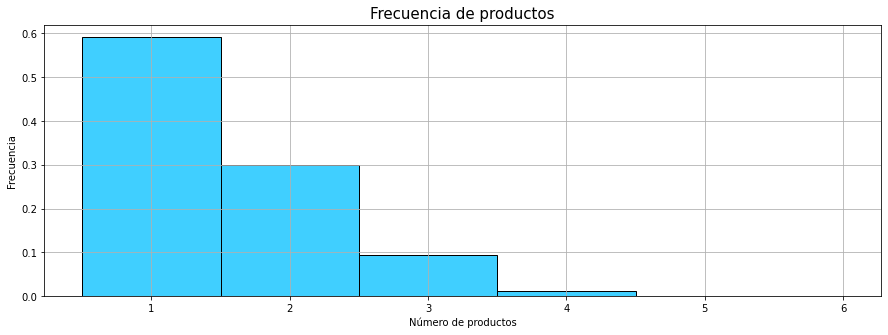

In [48]:
fig, ax = plt.subplots(figsize = (15,5))

sns.histplot(dist_product,stat="probability", color='deepskyblue', binwidth=0.5, shrink=2)

plt.title('Frecuencia de productos', size=15)
plt.xlabel("Número de productos")
plt.ylabel("Frecuencia")
plt.tick_params(left=True, bottom=True)
plt.grid(True)

La distribución de los clientes que tienen cuentas sigue una distribución de pareto, la mayoría de clientes tiene solamente una cuenta, sin embargo, se evidencia que existe tambien un grupo de clientes considerables que tienen dos productos. En orden de refinar el algoritmo en la predicción de pago se hace mucho más importante predecir que los clientes que tengan más de una cuenta, dado que si un cliente que tenga cuatro productos, por ejemplo, desmoejora en un producto su pago es problable que esto repercuta en los otros productos del banco. Para esto los que se propone como primer modelo será hacer uns arquitectura de redes neuronales gemelas.

Como primer paso se debe elegir un cliente y ver los productos asociados, para poder evidenciar su comportamiento de pago 

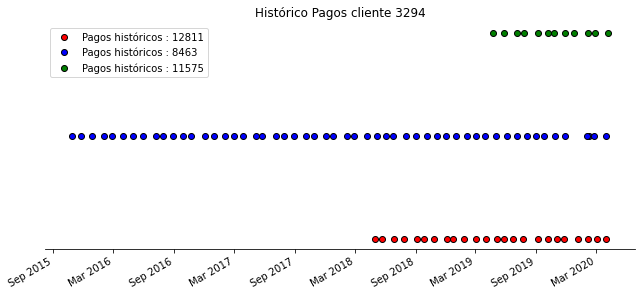

In [49]:
cliente = 3294

#for i in range(N_clientes):
n_contratos = len(data["ID_CONTRATO"][(data["ID_CONTRATO"] != np.nan) & (data["ID_CLIENTE"] == cliente )].unique())
contratos = data["ID_CONTRATO"][(data["ID_CONTRATO"] != np.nan) & (data["ID_CLIENTE"] == cliente )].unique()
fecha_pago_contrato = []

for i in range(n_contratos):  
    fecha_pago_contrato.append(pd.to_datetime(data["FECHA_PAGO"][data["ID_CONTRATO"]==contratos[i]]))
    
fig, ax = plt.subplots(figsize=(8.8, 4), constrained_layout=True)
ax.set(title="Histórico Pagos cliente {}".format(cliente))

color = [ "red", "blue", "green", "yellow", "purple", "orange"]

for i in range(n_contratos):
    ax.plot(fecha_pago_contrato[i], i+np.zeros_like(fecha_pago_contrato[i]), "ro",
        color="k", markerfacecolor=color[i], label="Pagos históricos : {}".format(int(contratos[i])))
    
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.setp(ax.get_xticklabels(), rotation=30, ha="right")

# remove y axis and spines
ax.yaxis.set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)


plt.legend()
    

A simple vista no se puede tener alguna correlación evidente para estas series temporales, antes de plantear alguna estadística se hace la binarización de los contratos asociados al cliente para poder establecer una comparación objetiva

0
-916
-1273


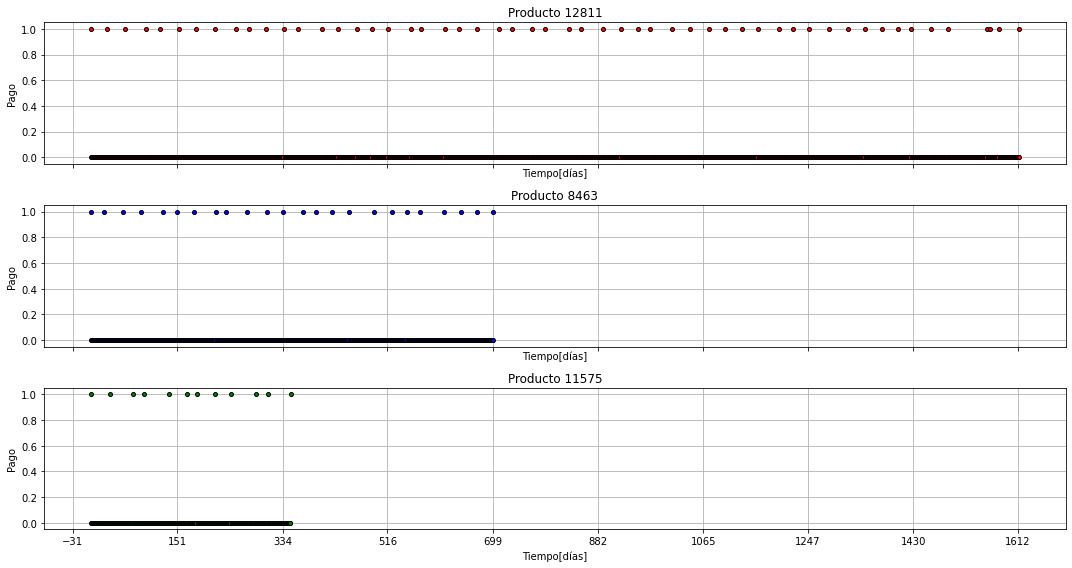

In [50]:
# list to save range life time of product
time_product = []
pagos = []
labels_time = []


for i in range(n_contratos):
    time_product.append(pd.date_range(fecha_pago_contrato[i].min(), fecha_pago_contrato[i].max()))
    pagos.append(np.zeros(len(time_product[i])))
    labels_time.append(np.arange(len(time_product[i])))
    
    for j in range(len(fecha_pago_contrato[i])):
        index_to_replace = np.where(time_product[i] == fecha_pago_contrato[i].iloc[j])
        pagos[i][index_to_replace] = 1
    

fig, axs = plt.subplots(nrows=n_contratos, figsize=(15,8), sharex=True, sharey=True)

# set the most longer like reference
labels_time = sorted(labels_time, key=len, reverse=True)
pagos = sorted(pagos, key=len, reverse=True)
fecha_pago_contrato = sorted(fecha_pago_contrato, key=len, reverse=True)

for i in range(n_contratos):
    x_off = (fecha_pago_contrato[0].min() - fecha_pago_contrato[i].min()).days
    print(x_off)
    axs[i].plot(labels_time[i], pagos[i], "ro", color="k", markerfacecolor=color[i],markersize=4)
    axs[i].set_title(f"Producto {int(contratos[i])}")
    axs[i].xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    axs[i].set_xlabel("Tiempo[días]")
    axs[i].set_ylabel("Pago")
    axs[i].grid(True)

plt.tight_layout()

In [ ]:
fecha_pago_contrato[0].min(), fecha_pago_contrato[1].min(), fecha_pago_contrato[2].min()

In [ ]:
def jaccard_similarity(x1, x2):
    s1 = set(x1)
    s2 = set(x2)
    
    return float(len(s1.intersection(s2))/len(s1.union(s2)))
    

Para tener una comparación objetiva de las "similitudes" básicamente , la serie puede pensarse como un efecto a observar en un rango $i = 1,2,\dots, n$. como variables aleatorias de Bernoulli no idénticamente distribuidas y posiblemente dependientes

$$Y_{i}\sim \mathcal{B}(\pi_{i})$$

donde $\pi_{i}$ es una probabilidad de éxito que cambia con el tiempo y puede depender de algunos factores externos, correlacionarse automáticamente. Si se tuvieran nua muestra de variables aleatorias de Bernoulli la media sería un estimador de máxima verosimilitud del parámetro $\pi$. En este caso se está tomando sobre diferentes $\pi_{i}$ para diferentes $Y_{i}$, esto ayuda mucho hasta que se evidencia que si se asume la dependencia temporal entre los valores, entonces al tiempo también se asume que los valores en los punto en el tiempo que estan cercas unos de otros son similares. Esto podría significar que es adecuado el uso de la media móvil con un ancho de ventana predefinico $2h + 1$ para estimar la media móvil 

$$\hat{m}_{i} = (2h+1)^{-1}\sum_{j=-h}^{h}y_{i+j}, \qquad h=\frac{n-1}{2}$$

Otro enfoque sería asumir 


Using TensorFlow backend.


cpu disponible!
Reading data ...
Prediction of product = 12522.0
Preparation of fata ...
Horizont days = 90
Fitting the model ...
Epoch 1/10
90/90 [==============================] - 44s 487ms/step - loss: 0.5488 - accuracy: 0.3333
Epoch 2/10
90/90 [==============================] - 41s 455ms/step - loss: 0.5210 - accuracy: 0.5000
Epoch 3/10
90/90 [==============================] - 42s 465ms/step - loss: 0.4734 - accuracy: 0.7667
Epoch 4/10
90/90 [==============================] - 42s 469ms/step - loss: 0.4559 - accuracy: 0.8000
Epoch 5/10
90/90 [==============================] - 43s 473ms/step - loss: 0.4313 - accuracy: 0.9333
Epoch 6/10
90/90 [==============================] - 43s 474ms/step - loss: 0.3863 - accuracy: 0.9556
Epoch 7/10
90/90 [==============================] - 66s 738ms/step - loss: 0.3722 - accuracy: 0.9667
Epoch 8/10
90/90 [==============================] - 41s 458ms/step - loss: 0.3226 - accuracy: 0.9667
Epoch 9/10
90/90 [==============================] - 42s 466ms/

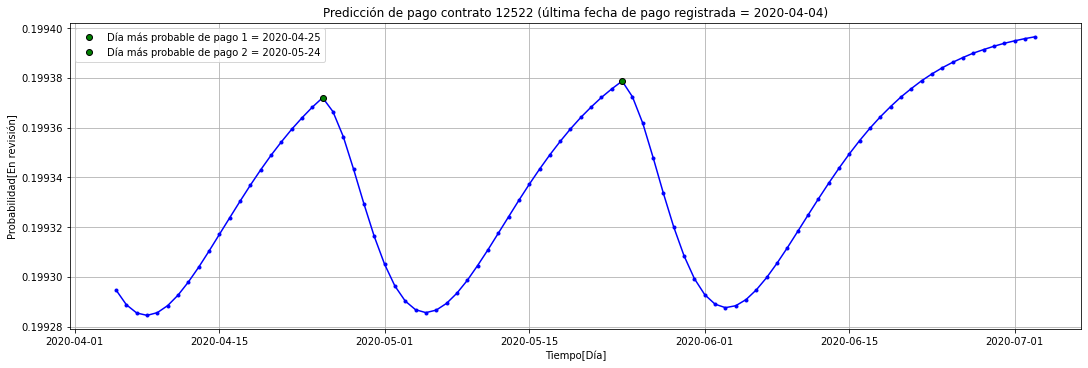

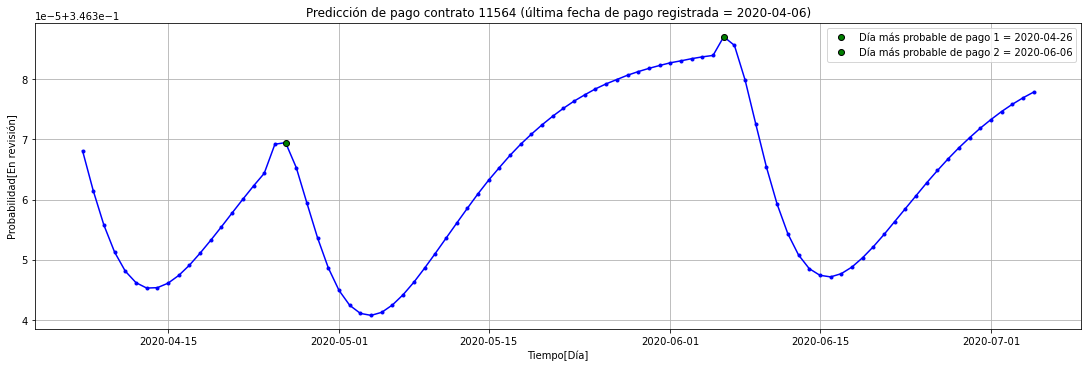

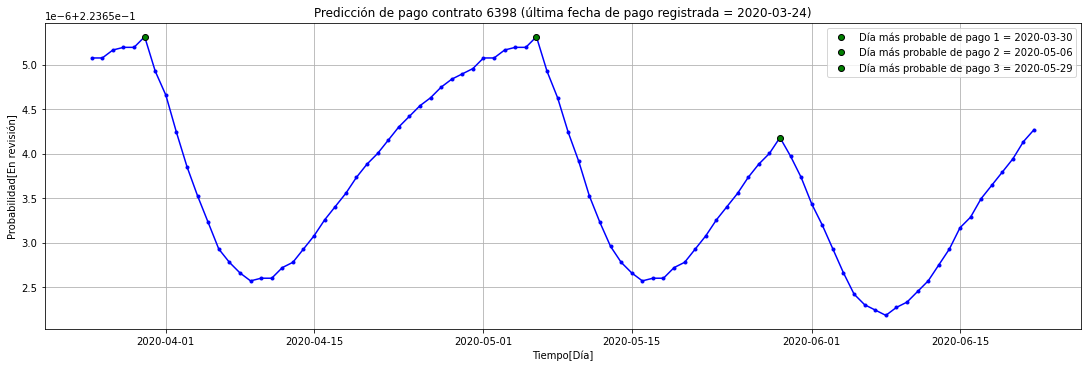

In [1]:
%run prediccion_pago.py